# QE installation
```bash
module load cpu PrgEnv-gnu cray-hdf5-parallel cray-fftw

./configure CC=cc CXX=CC FC=ftn MPIF90=mpif90 --enable-openmp --enable-parallel --disable-shared --with-scalapack=yes --with-hdf5=${HDF5_DIR} --with-libxc=yes --with-libxc-prefix=/global/homes/w/wfang/libxc-5.2.3
```

Add the following path in make.inc
```bash
FFT_LIBS       = $(FFTW_DIR)/libfftw3.so \
               $(FFTW_DIR)/libfftw3_threads.so \
               $(FFTW_DIR)/libfftw3_omp.so
HDF5_LIBS = $(HDF5_DIR)/lib/libhdf5hl_fortran.so \
                $(HDF5_DIR)/lib/libhdf5_hl.so \
                $(HDF5_DIR)/lib/libhdf5_fortran.so \
                $(HDF5_DIR)/lib/libhdf5.so -lz -ldl
```


# Octopus installation


There are several useful links:
- https://neelravi.com/post/octopus-xsede/
- https://octopus-code.org/documentation/13/manual/installation/specific_architectures/  

To install on Permultter NERSC, first load the modules:
```bash
module load cpu PrgEnv-gnu cray-fftw gsl cray-hdf5-parallel cray-netcdf-hdf5parallel
```
1. libxc
```bash
wget https://gitlab.com/libxc/libxc/-/archive/5.2.3/libxc-5.2.3.tar.gz
autoreconf -i
./configure --prefix=`pwd` CC=cc FC=ftn FCFLAGS="-O3" CFLAGS="-O3"
make -j4 install
```
2. octopus
```bash
./configure --prefix=`pwd` --with-libxc-prefix=/global/homes/w/wfang/libxc-5.2.3 --enable-mpi CC=cc CXX=CC FC=ftn FCFLAGS="-fallow-argument-mismatch -O3" CFLAGS="-O3" FCCPP="/lib/cpp -ffreestanding" > out
make -j4 install
```


# [Magnons](https://www.octopus-code.org/documentation/11/tutorial/unsorted/magnons/)

## 1. Ground-state
### input file
```
CalculationMode = gs
PeriodicDimensions = 3 
BoxShape = parallelepiped
ExperimentalFeatures = yes
PseudopotentialSet=pseudodojo_lda
a = 2.867*Angstrom
%LatticeParameters
a | a | 2*a
90| 90| 90
%
%ReducedCoordinates
"Fe" | 0.0 | 0.0 | 0.0
"Fe" | 1/2 | 1/2 | 1/4
"Fe" | 0.0 | 0.0 | 1/2
"Fe" | 1/2 | 1/2 | 3/4
%
Spacing = 0.35
%KPointsGrid
4 | 4 | 2
%
Smearing = 0.1*eV
SmearingFunction = fermi_dirac
LCAOStart = lcao_states
SpinComponents = spinors
GuessMagnetDensity = user_defined
%AtomsMagnetDirection
0.0 | 0.0 | 4.0
0.0 | 0.0 | 4.0
0.0 | 0.0 | 4.0
0.0 | 0.0 | 4.0
%
EigenSolver = rmmdiis
ConvRelDens = 1e-7
ExtraStates = 20
```

### Output
The calculation was finished within 8 minutes with 8 cores.
- Before performing SCF, a LCAO is done. 
- The final magnetic moments on Fe atoms are not equal in the second digits. (2.55, 2.52, 2.57, 2.52) 

## 2. Time-dependent run

### Magnon kick
- The strength of the kick. This determines how strongly we perturb the system. ```TDDeltaStrengthMode = kick_magnon, TDDeltaStrength = 0.01```
- The momentum of the kick. This is the momentum of the spin spiral we are imposing to the system’s spins. ```TDMomentumTransfer```
- The easy axis of the material. This is usually the z direction, but the code allows for defining an arbitrary direction. This direction is used to determine the transverse magnetization from the total magnetization computed in Cartesian coordinates. ```TDEasyAxis```

### Input file
```
CalculationMode = td
PeriodicDimensions = 3 
BoxShape = parallelepiped
ExperimentalFeatures = yes
PseudopotentialSet=pseudodojo_lda
a = 2.867*Angstrom
%LatticeParameters
a | a | 2*a
90| 90| 90
%
%ReducedCoordinates
"Fe" | 0.0 | 0.0 | 0.0
"Fe" | 1/2 | 1/2 | 1/4
"Fe" | 0.0 | 0.0 | 1/2
"Fe" | 1/2 | 1/2 | 3/4
%
Spacing = 0.35
%KPointsGrid
4 | 4 | 2
%
RestartFixedOccupations = yes
SpinComponents = spinors

ExtraStates = 8

RestartWriteInterval = 5000
TDDeltaStrength = 0.01
TDDeltaStrengthMode = kick_magnon
%TDMomentumTransfer
0 | 0 | 2*pi/a/2 
%
%TDEasyAxis
0 | 0 | 1
%
TDTimeStep = 0.075
TDPropagator = aetrs
TDExponentialMethod = lanczos
TDExpOrder = 16
TDPropagationTime = 1800
%TDOutput
total_magnetization
energy
%
```
### Output

The time-dependent calculation produce ```Iter, Time, Energy, SC Steps, Elapsed Time```.


### Computing the transverse spin susceptibility

The header of ```total_magnetization``` contains: ```# Iter, t, Re[m_x(q)], Im[m_x(q)], Re[m_y(q)], Im[m_y(q)], Re[m_z(q)], Im[m_z(q)], Re[m_x(-q)], Im[m_x(-q)], Re[m_y(-q)], Im[m_y(-q)], Re[m_z(-q)], Im[m_z(-q)]```.

In the calculation folder, run ```/global/homes/w/wfang/octopus-13.0/bin/oct-spin_susceptibility```. This will generate ```td.general/transverse_magnetization_q001``` and ```td.general/spin_susceptibility_q001```. The header of ```transverse_magnetization_q001``` is ```# time, Re[m_+(q,t)], Im[m_+(q,t)], Re[m_-(-q, t)], Im[m_-(-q,t)], Re[m_z(q,t)], Im[m_z(q,t)], Re[m_z(-q,t)], Im[m_z(-q,t)]```. The header of ```transverse_magnetization_q001``` is ```energy, Re[\chi_{+-}(q)], Im[\chi_{+-}(q)], Re[\chi_{-+}(-q)], Im[\chi_{-+}(-q)], Re[\chi_{zz}(q)], Im[\chi_{zz}(q)], Re[\chi_{zz}(-q)], Im[\chi_{zz}(-q)```.

Text(0, 0.5, '$\\mathrm{Im}[\\chi_{+-}(q)]$')

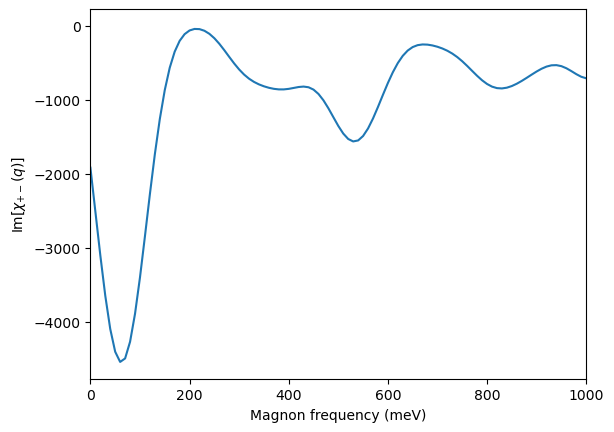

In [21]:
# plot
import numpy as np
import matplotlib.pyplot as plt

# energy Re[\chi_{+-}(q)] Im[\chi_{+-}(q)] Re[\chi_{-+}(-q)] Im[\chi_{-+}(-q)] Re[\chi_{zz}(q)] Im[\chi_{zz}(q)] Re[\chi_{zz}(-q)] Im[\chi_{zz}(-q)]

data1 = np.loadtxt('td.general/spin_susceptibility_q001', comments='#')

# convert to meV
energy = data[:,0] * 1000 * 27.2

plt.figure()
# \chi_{+-}(q)
plt.plot(energy, data[:, 2])

plt.xlim(0, 1000)
plt.xlabel('Magnon frequency (meV)')
plt.ylabel(r'$\mathrm{Im}[\chi_{+-}(q)]$')